In [535]:
%matplotlib inline
import os
import gc
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import normalize,to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping
from keras.layers import BatchNormalization,Conv2D,MaxPool2D,Flatten,Dense,Dropout 
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array, array_to_img
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
import warnings
warnings.filterwarnings('ignore')
print(os.listdir("/Users/susovan/Desktop/springboard doc/ship dataset"))



['.DS_Store', 'model2.hdf5', 'model1.hdf5', 'train', 'test_ApKoW4T.csv', 'sample_submission_ns2btKE.csv']


In [536]:
# the path for loading .jpg images
path = "/Users/susovan/Desktop/springboard doc/ship dataset/train/images"

train_files = pd.read_csv('/Users/susovan/Desktop/springboard doc/ship dataset/train/train.csv', 
                          dtype={'image': 'object', 'category': 'int8'})

test_files = pd.read_csv('/Users/susovan/Desktop/springboard doc/ship dataset/test_ApKoW4T.csv')

In [537]:
train_files

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2
...,...,...
6247,2881056.jpg,3
6248,1145083.jpg,2
6249,2898652.jpg,5
6250,2868175.jpg,3


In [538]:
train_files.dtypes

image       object
category      int8
dtype: object

In [539]:
test_files.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


In [540]:
# display missing categories in train
train_files[train_files.isnull().any(axis=1)]

,image,category


In [541]:
# dictionary ship encoding 
ship = {'Cargo': 1, 
        'Military': 2, 
        'Carrier': 3, 
        'Cruise': 4, 
        'Tankers': 5}

# reverse the ship type dictionary
ship = dict([[v,k] for k,v in ship.items()])
ship

{1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tankers'}

In [542]:
# Create test labels for interpretability
train_files['ship'] = train_files['category'].map(ship).astype('category')
print(train_files)
labels = list(train_files['ship'].unique())
labels

            image  category      ship
0     2823080.jpg         1     Cargo
1     2870024.jpg         1     Cargo
2     2662125.jpg         2  Military
3     2900420.jpg         3   Carrier
4     2804883.jpg         2  Military
...           ...       ...       ...
6247  2881056.jpg         3   Carrier
6248  1145083.jpg         2  Military
6249  2898652.jpg         5   Tankers
6250  2868175.jpg         3   Carrier
6251  2784171.jpg         1     Cargo

[6252 rows x 3 columns]


['Cargo', 'Military', 'Carrier', 'Cruise', 'Tankers']

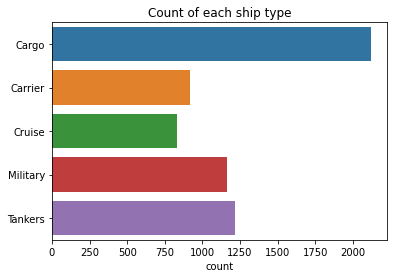

In [543]:
# display count of ship types
plt.title('Count of each ship type')
sns.countplot(y=train_files['ship'].values)
plt.show()


In [544]:
a=train_files['ship'].value_counts(normalize=False)
a

Cargo       2120
Tankers     1217
Military    1167
Carrier      916
Cruise       832
Name: ship, dtype: int64

In [545]:
train_files['ship'].value_counts(normalize=True)

Cargo       0.339091
Tankers     0.194658
Military    0.186660
Carrier     0.146513
Cruise      0.133077
Name: ship, dtype: float64

In [546]:

def load(what='train', target_size=(224,224)):
    array = []
    if what =='train':
        for file in tqdm(train_files['image'].values):
            img = load_img(os.path.join(path, file), target_size=target_size)
            img = img_to_array(img)/255. # normalize image tensor
            array.append(img)
    elif what =='test':
        for file in tqdm(test_files['image'].values):
            img = load_img(os.path.join(path, file), target_size=target_size)
            img = img_to_array(img)/255. # normalize image tensor
            array.append(img)
    gc.collect()
    return np.asarray(array)




In [547]:
# Load Train and Test
X_train = load()
test = load('test')
print(f'train dtype: {X_train.dtype}')
print(f'test dtype: {test.dtype}')
print(f'train shape: {X_train.shape}')

100%|██████████| 2680/2680 [00:05<00:00, 504.42it/s]


train dtype: float32
test dtype: float32
train shape: (6252, 224, 224, 3)


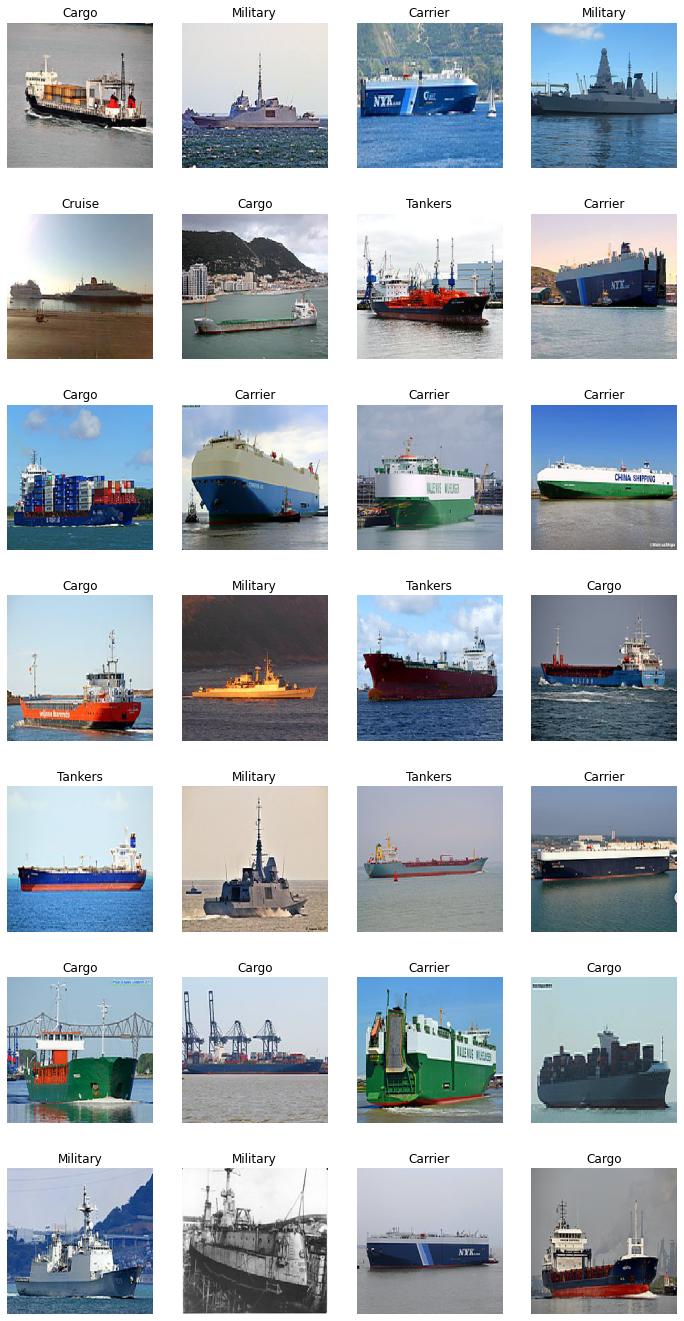

53069

In [548]:
# visualize the top 28 train images
plt.figure(figsize=(12,24))

for i in range(1,29):
    plt.subplot(7,4,i)
    plt.title(f'{train_files["ship"].values[i]}')
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()
gc.collect()

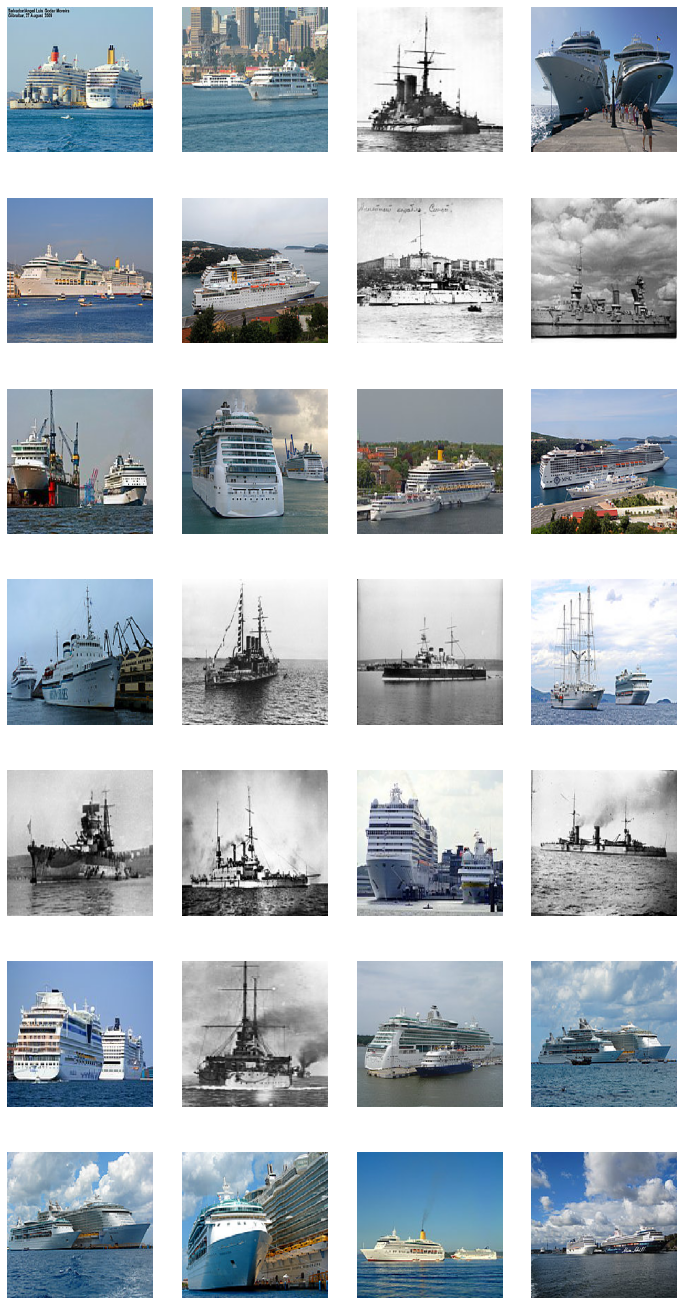

53069

In [549]:
# visualize the top 28 test images
plt.figure(figsize=(12,24))

for i in range(1,29):
    plt.subplot(7,4,i)
    plt.imshow(test[i])
    plt.axis('off')
plt.show()
del test # free up space for training
gc.collect()

In [286]:
def rgb2gray(rgb):
    """Convert from color image (RGB) to grayscale.
       Source: opencv.org
       grayscale = 0.299*red + 0.587*green + 0.114*blue
    Argument:
        rgb (tensor): rgb image
    Return:
        (tensor): grayscale image
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

x_train_gray = rgb2gray(X_train)
#x_test_gray = rgb2gray(test)


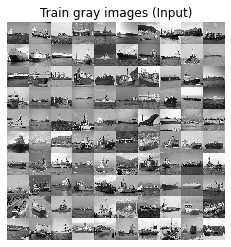

In [287]:
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
channels = X_train.shape[3]
imgs = x_train_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Train gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
#plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

In [288]:
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

In [289]:
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
#x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

In [550]:
ohe = OneHotEncoder(dtype='int8', sparse=False)
y_train = ohe.fit_transform(train_files['category'].values.reshape(-1,1))
print(y_train.shape)
print(X_train.shape)

(6252, 5)
(6252, 224, 224, 3)


In [551]:
#custom callbacks function that calculates f1 score after every epoch to gauge model performance

class printf1(callbacks.Callback):
    def __init__(self, X_train, y_train):
        super(printf1, self).__init__()
        self.bestf1 = 0
        self.X_train = X_train
        self.y_train = y_train
        
    def on_epoch_end(self, epoch, logs={}):
        pred = np.argmax(self.model.predict(np.array(self.X_train)), axis=1)
        f1 = f1_score(np.argmax(self.y_train, axis=1), pred, average='weighted')
        print("Train F1 Score: {:.4f}".format(f1))
        pred = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        f1 = f1_score(np.argmax(self.validation_data[1], axis=1), pred, average='weighted')
        print("Valid F1 Score: {:.4f}".format(f1))
        return

In [552]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    gc.collect()

In [333]:
X2_train, X2_test, y2_train, y2_test = train_test_split(x_train_gray, y_train, 
                                                    stratify=y_train,
                                                    random_state=20,
                                                    test_size=0.2)
                                                   
    
print(X1_train.shape)
print(X_test.shape)
print(y1_train.shape)
print(y_test.shape)

(5001, 120, 120, 3)
(1251, 120, 120, 3)
(5001, 5)
(1251, 5)


In [553]:
X1_train, X_test, y1_train, y_test = train_test_split(X_train, y_train, 
                                                    stratify=y_train,
                                                    random_state=20,
                                                    test_size=0.2)
                                                   
    
print(X1_train.shape)
print(X_test.shape)
print(y1_train.shape)
print(y_test.shape)

(5001, 224, 224, 3)
(1251, 224, 224, 3)
(5001, 5)
(1251, 5)


In [403]:
#Without Data augmentation
#CNN with relu activation
from keras.constraints import maxnorm
model = Sequential()
model.add(Conv2D(128,3,padding="same", activation="relu", input_shape=(120,120,3)))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.2))


#model.add(Conv2D(16, 3, padding="same", activation="relu"))
#model.add(BatchNormalization())
#model.add(MaxPool2D())
#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, kernel_constraint=maxnorm(3), activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Dense(64, kernel_constraint=maxnorm(3), activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, kernel_constraint=maxnorm(3), activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(5, activation="softmax"))



opt = Adam(lr=0.000001)
model.compile(optimizer = 'adam' , 
              loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()



Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 120, 120, 128)     3584      
_________________________________________________________________
batch_normalization_129 (Bat (None, 120, 120, 128)     512       
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 60, 60, 128)       0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 60, 60, 128)       0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 60, 60, 64)        73792     
_________________________________________________________________
batch_normalization_130 (Bat (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 30, 30, 64)      

In [339]:
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=5)

In [533]:
#Without data augmentation
#history = model.fit(
                #X2_train,y2_train, epochs=75,validation_data = (X2_test, y2_test))
#model.save('/Users/susovan/Desktop/springboard doc/ship dataset/model1.hdf5') 
#, callbacks=[es]

In [404]:
history = model.fit(
                X1_train,y1_train, epochs=75,validation_data = (X_test, y_test))
model.save('/Users/susovan/Desktop/springboard doc/ship dataset/model2.hdf5') 

Epoch 1/75
157/157 [==============================] - 317s 2s/step - loss: 1.7132 - accuracy: 0.2975 - val_loss: 1.9034 - val_accuracy: 0.2246
Epoch 2/75
157/157 [==============================] - 303s 2s/step - loss: 1.3819 - accuracy: 0.4273 - val_loss: 1.5027 - val_accuracy: 0.3301
Epoch 3/75
157/157 [==============================] - 299s 2s/step - loss: 1.1699 - accuracy: 0.5127 - val_loss: 1.2724 - val_accuracy: 0.4396
Epoch 4/75
157/157 [==============================] - 301s 2s/step - loss: 1.0402 - accuracy: 0.5749 - val_loss: 1.0858 - val_accuracy: 0.5420
Epoch 5/75
157/157 [==============================] - 316s 2s/step - loss: 0.9443 - accuracy: 0.6297 - val_loss: 1.3287 - val_accuracy: 0.5036
Epoch 6/75
157/157 [==============================] - 296s 2s/step - loss: 0.8542 - accuracy: 0.6639 - val_loss: 0.8484 - val_accuracy: 0.6603
Epoch 7/75
157/157 [==============================] - 308s 2s/step - loss: 0.8041 - accuracy: 0.6837 - val_loss: 1.0815 - val_accuracy: 0.5915

Epoch 58/75
157/157 [==============================] - 287s 2s/step - loss: 0.1451 - accuracy: 0.9526 - val_loss: 0.6948 - val_accuracy: 0.7946
Epoch 59/75
157/157 [==============================] - 291s 2s/step - loss: 0.1231 - accuracy: 0.9592 - val_loss: 0.7570 - val_accuracy: 0.7834
Epoch 60/75
157/157 [==============================] - 293s 2s/step - loss: 0.1514 - accuracy: 0.9520 - val_loss: 0.8803 - val_accuracy: 0.7562
Epoch 61/75
157/157 [==============================] - 312s 2s/step - loss: 0.1602 - accuracy: 0.9438 - val_loss: 0.7596 - val_accuracy: 0.7818
Epoch 62/75
157/157 [==============================] - 293s 2s/step - loss: 0.1299 - accuracy: 0.9558 - val_loss: 1.0721 - val_accuracy: 0.7146
Epoch 63/75
157/157 [==============================] - 291s 2s/step - loss: 0.1396 - accuracy: 0.9562 - val_loss: 0.8283 - val_accuracy: 0.7722
Epoch 64/75
157/157 [==============================] - 293s 2s/step - loss: 0.1246 - accuracy: 0.9576 - val_loss: 0.7251 - val_accuracy:

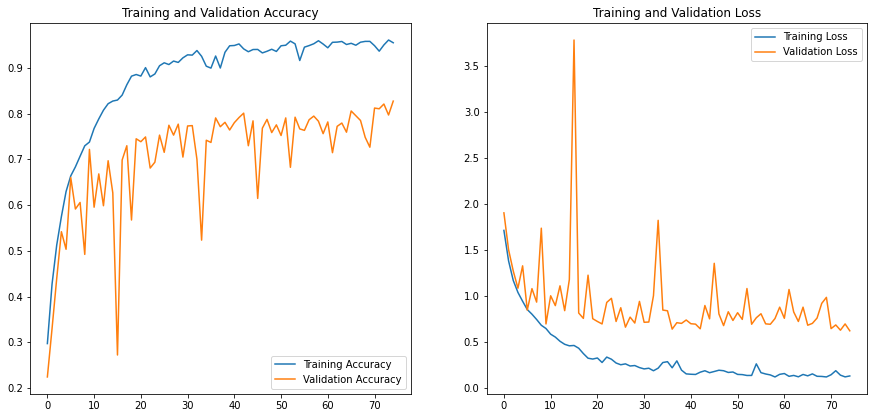

In [405]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(75)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [406]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 82.73%


In [407]:
from keras.models import load_model
f1 = printf1(X1_train, y1_train)
cp = ModelCheckpoint('best.hdf5', monitor='val_loss', save_best_only=True)


true = np.argmax(y_test, axis=1)
best = load_model('best.hdf5')
valid_pred_best = np.argmax(best.predict(X_test), axis=1)
valid_pred = np.argmax(model.predict(X_test), axis=1)
#best_f1_score =f1_score(true, valid_pred_best, average="weighted")
#print(f'Best model weighted F1 Score: {best_f1_score:.4f}')
#f1_score = f1_score(true, valid_pred, average="weighted")
#print(f'weighted F1 Score: {f1_score:.4f}')


In [437]:
#from sklearn.metrics import classification_report, confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
#import seaborn as sns

# Predicting labels from X_test data
y_pred = model.predict(X_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
#y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test labels from one hot encoding to list
#y_test_classes = np.argmax(y_test, axis = 1)

# Create the confusion matrix
#confmx = confusion_matrix(y_test_classes, y_pred_classes)
#f, ax = plt.subplots(figsize = (8,8))
#sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
#plt.xlabel('Predicted Labels')
#plt.ylabel('True Labels')
#plt.title('Confusion Matrix')
#plt.show();





In [381]:
#labels

In [444]:
#print(classification_report(y_test, y_pred, target_names = ['Cargo (Class 0)','Cruise (Class 1)', 
                                                      
                                        #'Military (Class 2)','Carrier (Class 3)', 'Tankers (Class 4)']))

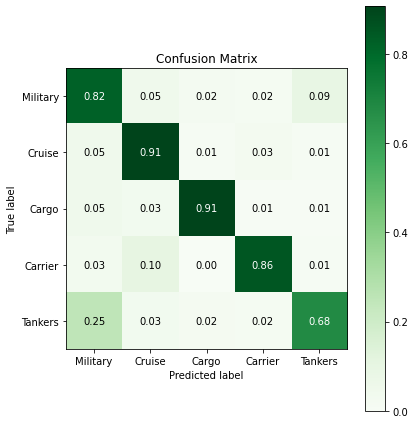

In [435]:
plot_confusion_matrix(true, valid_pred, normalize=True, 
                      classes=labels, title='Confusion Matrix')

In [413]:
test1 = load('test')
sub = pd.read_csv('/Users/susovan/Desktop/springboard doc/ship dataset/sample_submission_ns2btKE.csv')
#if best_f1_score >= f1_score:
    #sub['category'] = np.argmax(best.predict(test1), axis=1) + 1
    
#else:
sub['category'] = np.argmax(model.predict(test1), axis=1) + 1 
    
sub.to_csv('submission.csv', index=False)
sub.head()

100%|██████████| 2680/2680 [00:04<00:00, 661.58it/s]


,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,2


In [415]:
sub['category'].map(ship).value_counts(normalize=True)

Cargo       0.355597
Military    0.201866
Tankers     0.172388
Carrier     0.148134
Cruise      0.122015
Name: category, dtype: float64

In [416]:
sub['ship'] = sub['category'].map(ship).astype('category')
print(sub)
print(sub['ship'].unique())
#labels = list(sub['ship'].unique())
#labels

            image  category      ship
0     1007700.jpg         4    Cruise
1     1011369.jpg         4    Cruise
2     1051155.jpg         4    Cruise
3     1062001.jpg         2  Military
4     1069397.jpg         2  Military
...           ...       ...       ...
2675   950995.jpg         4    Cruise
2676   951046.jpg         4    Cruise
2677   951323.jpg         4    Cruise
2678   952113.jpg         2  Military
2679   953982.jpg         2  Military

[2680 rows x 3 columns]
[Cruise, Military, Cargo, Tankers, Carrier]
Categories (5, object): [Cruise, Military, Cargo, Tankers, Carrier]


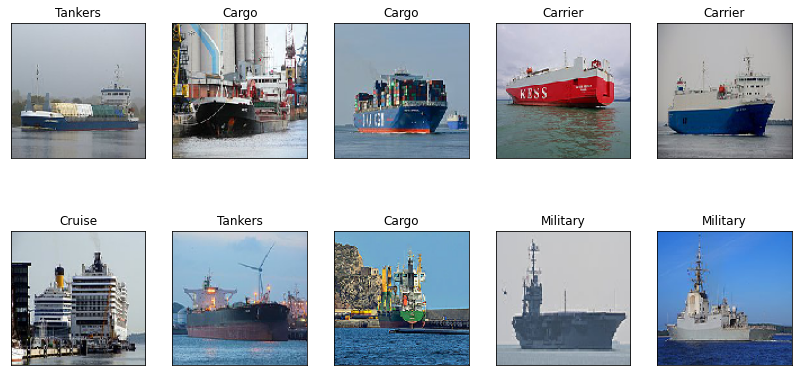

In [432]:
              
indices = np.random.randint(0,2680,10) 
i = 1
plt.figure(figsize=(14,7))
for each in indices:
    plt.subplot(2,5,i)
    plt.imshow(test1[each])
    plt.title(f'{sub["ship"].values[each]}')
    plt.xticks([])
    plt.yticks([])
    i += 1

In [559]:
from keras.applications.xception import Xception
model = Xception(include_top=False, input_shape=(224,224,3))

In [560]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

x = GlobalAveragePooling2D()(model.output)
#x = Dense(6, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# define new model
model = Model(model.inputs, output)
model.save('model6.hdf5')

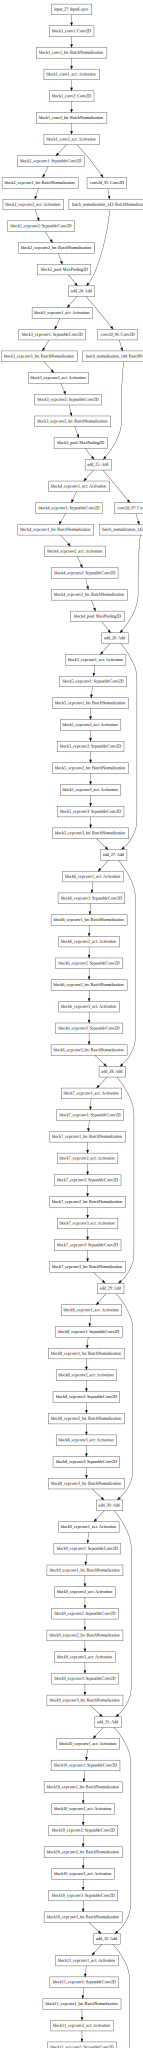

In [556]:
# visualize the Xception model architecture
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
# use ImageDataGenerator to augment training data
#from keras.optimizers import adam
#from keras.preprocessing.image import ImageDataGenerator
#batch_size = 8
#epochs = 50

# make sure to keep learning rate low when fine-tuning
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer=Adam(lr=0.0001))


#f1 = printf1(X1_train, y1_train)
#cp = ModelCheckpoint('best.hdf5', monitor='val_loss', save_best_only=True)
#annealer = LearningRateScheduler(lambda x: 1e-4 * 0.95 ** x)



history = model.fit(
                X1_train,y1_train, epochs=75,validation_data = (X_test, y_test))


Epoch 1/75
157/157 [==============================] - 6856s 44s/step - loss: 0.4995 - accuracy: 0.8292 - val_loss: 0.1815 - val_accuracy: 0.9361
Epoch 2/75
157/157 [==============================] - 4768s 30s/step - loss: 0.0797 - accuracy: 0.9754 - val_loss: 0.3110 - val_accuracy: 0.9057
Epoch 3/75
157/157 [==============================] - 4698s 30s/step - loss: 0.0326 - accuracy: 0.9926 - val_loss: 0.1806 - val_accuracy: 0.9464
Epoch 4/75
157/157 [==============================] - 4191s 27s/step - loss: 0.0211 - accuracy: 0.9932 - val_loss: 0.1667 - val_accuracy: 0.9512
Epoch 5/75
157/157 [==============================] - 3966s 25s/step - loss: 0.0262 - accuracy: 0.9946 - val_loss: 0.1741 - val_accuracy: 0.9424
Epoch 6/75
157/157 [==============================] - 4103s 26s/step - loss: 0.0143 - accuracy: 0.9954 - val_loss: 0.1682 - val_accuracy: 0.9528
Epoch 7/75
157/157 [==============================] - 4023s 26s/step - loss: 0.0164 - accuracy: 0.9956 - val_loss: 0.1919 - val_ac

In [35]:
#Without Data augmentation
#CNN with sigmoid activation
model = Sequential()
model.add(Conv2D(128, 3, activation = 'sigmoid', padding = 'VALID', input_shape = (120,120,3)))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(64, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(32, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(32, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(16, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.4))
#model.add(Conv2D(8, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))



model.add(Flatten())
model.add(Dense(128, activation = 'sigmoid', kernel_initializer = 'he_uniform'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary())
model.save('model.hdf5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 118, 118, 128)     3584      
_________________________________________________________________
batch_normalization_8 (Batch (None, 118, 118, 128)     512       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 59, 59, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 57, 57, 64)        73792     
_________________________________________________________________
batch_normalization_9 (Batch (None, 57, 57, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 32)       

In [36]:

history = model.fit(
                X1_train, y1_train,
                epochs =15,
                validation_data = (X_test, y_test))

Epoch 1/15
157/157 [==============================] - 278s 2s/step - loss: 1.7819 - accuracy: 0.2833 - val_loss: 1.5818 - val_accuracy: 0.3389
Epoch 2/15
157/157 [==============================] - 277s 2s/step - loss: 1.4722 - accuracy: 0.4001 - val_loss: 1.6758 - val_accuracy: 0.3805
Epoch 3/15
157/157 [==============================] - 273s 2s/step - loss: 1.2735 - accuracy: 0.4649 - val_loss: 3.0736 - val_accuracy: 0.1503
Epoch 4/15
157/157 [==============================] - 269s 2s/step - loss: 1.1483 - accuracy: 0.5123 - val_loss: 1.1842 - val_accuracy: 0.5140
Epoch 5/15
157/157 [==============================] - 274s 2s/step - loss: 1.0520 - accuracy: 0.5523 - val_loss: 1.8201 - val_accuracy: 0.3549
Epoch 6/15
157/157 [==============================] - 269s 2s/step - loss: 0.9870 - accuracy: 0.5837 - val_loss: 1.7224 - val_accuracy: 0.4684
Epoch 7/15
157/157 [==============================] - 272s 2s/step - loss: 0.9250 - accuracy: 0.6157 - val_loss: 0.9964 - val_accuracy: 0.5931

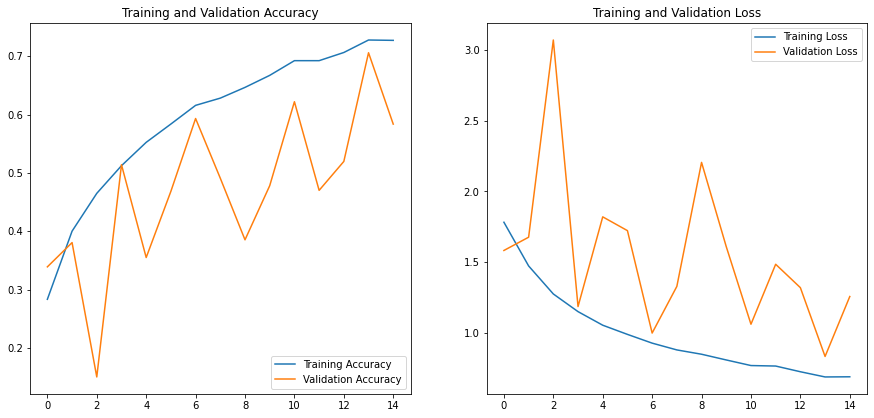

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [38]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 58.35%


In [43]:
from keras.models import load_model
f1 = printf1(X1_train, y1_train)
cp = ModelCheckpoint('best.hdf5', monitor='val_loss', save_best_only=True)


#true = np.argmax(y_test, axis=1)
#best = load_model('best.hdf5')
#valid_pred_best = np.argmax(best.predict(X_test), axis=1)
#best_f1_score = f1_score(true, valid_pred_best, average="weighted")
#print(f'Best model weighted F1 Score: {best_f1_score:.4f}')

In [40]:
valid_pred = np.argmax(model.predict(X_test), axis=1)
f1_score = f1_score(true, valid_pred, average="weighted")
print(f'weighted F1 Score: {f1_score:.4f}')


weighted F1 Score: 0.5832


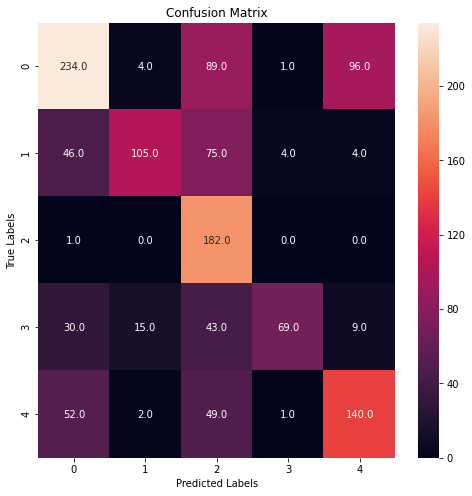

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicting labels from X_test data
y_pred = model.predict(X_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)

# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();



In [44]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.64      0.55      0.59       424
           1       0.83      0.45      0.58       234
           2       0.42      0.99      0.59       183
           3       0.92      0.42      0.57       166
           4       0.56      0.57      0.57       244

    accuracy                           0.58      1251
   macro avg       0.68      0.60      0.58      1251
weighted avg       0.67      0.58      0.58      1251



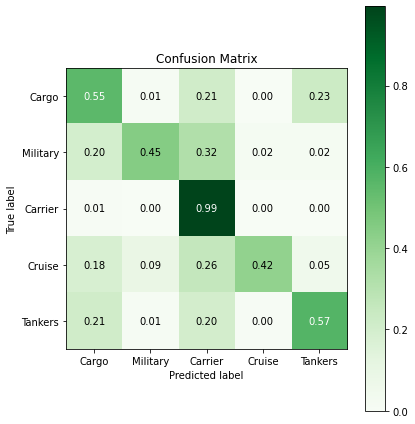

In [45]:
plot_confusion_matrix(true, valid_pred, normalize=True, 
                      classes=labels, title='Confusion Matrix')

In [385]:
#Data augmentation
batch_size = 100
epochs = 50
datagen = ImageDataGenerator(rotation_range=40,
                             horizontal_flip=True, 
                             width_shift_range=0.5, 
                             height_shift_range=0.5, 
                             zoom_range=[0.5,0.5],
                             dtype='float32')




datagen.fit(X_train, augment=True, rounds=1, seed=20)
train_generator = datagen.flow(X1_train, y1_train, 
                               batch_size=batch_size, 
                               seed=20)
            



In [386]:
#With Data augmentation
#CNN with relu activation

from keras.constraints import maxnorm
model = Sequential()
model.add(Conv2D(128,3,padding="same", activation="relu", input_shape=(120,120,3)))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.2))


model.add(Conv2D(16, 3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(128, kernel_constraint=maxnorm(3), activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Dense(64, kernel_constraint=maxnorm(3), activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, kernel_constraint=maxnorm(3), activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(5, activation="softmax"))



opt = Adam(lr=0.000001)
model.compile(optimizer = 'adam' , 
              loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 120, 120, 128)     3584      
_________________________________________________________________
batch_normalization_122 (Bat (None, 120, 120, 128)     512       
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 60, 60, 128)       0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 60, 60, 128)       0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 60, 60, 64)        73792     
_________________________________________________________________
batch_normalization_123 (Bat (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 30, 30, 64)      

In [387]:
#With Data augmentation
history = model.fit_generator(train_generator,
                              epochs = epochs,
                              validation_data = (X_test, y_test)
                              )

Epoch 1/50
51/51 [==============================] - 584s 11s/step - loss: 1.9628 - accuracy: 0.2184 - val_loss: 1.5524 - val_accuracy: 0.3317
Epoch 2/50
51/51 [==============================] - 554s 11s/step - loss: 1.7160 - accuracy: 0.2563 - val_loss: 1.5543 - val_accuracy: 0.3373
Epoch 3/50
51/51 [==============================] - 608s 12s/step - loss: 1.6232 - accuracy: 0.2853 - val_loss: 1.5463 - val_accuracy: 0.3389
Epoch 4/50
51/51 [==============================] - 484s 9s/step - loss: 1.5769 - accuracy: 0.3009 - val_loss: 1.5609 - val_accuracy: 0.3389
Epoch 5/50
51/51 [==============================] - 455s 9s/step - loss: 1.5574 - accuracy: 0.3115 - val_loss: 1.5558 - val_accuracy: 0.3389
Epoch 6/50
51/51 [==============================] - 582s 11s/step - loss: 1.5343 - accuracy: 0.3197 - val_loss: 1.5518 - val_accuracy: 0.3389
Epoch 7/50
51/51 [==============================] - 598s 12s/step - loss: 1.5245 - accuracy: 0.3297 - val_loss: 1.5410 - val_accuracy: 0.3389
Epoch 8/

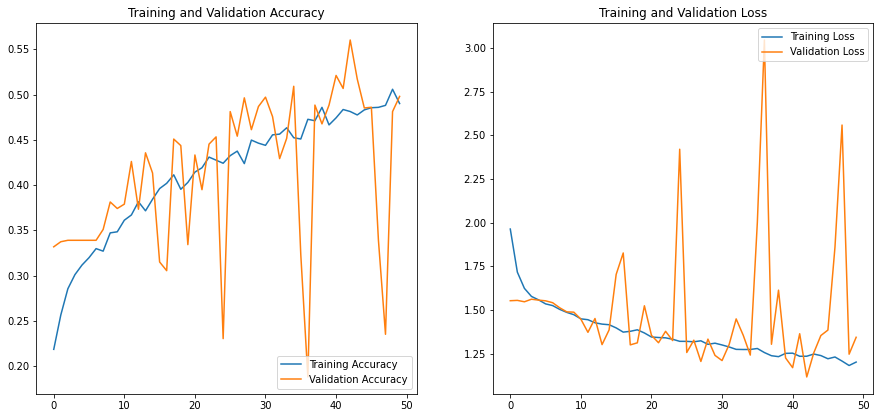

In [389]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [390]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 49.80%


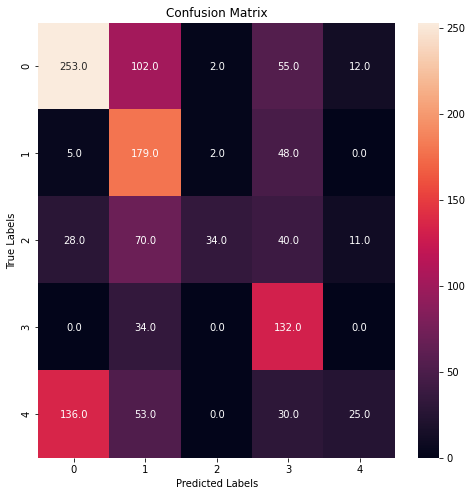

In [391]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicting labels from X_test data
y_pred = model.predict(X_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)

# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

In [398]:
print(classification_report(y_test_classes, y_pred_classes, target_names = ['Cargo (Class 0)','Cruise (Class 1)', 
                                                                            'Military (Class 2)','Carrier (Class 3)',
                                                                           'Tankers (Class 4)']))


                    precision    recall  f1-score   support

   Cargo (Class 0)       0.60      0.60      0.60       424
  Cruise (Class 1)       0.41      0.76      0.53       234
Military (Class 2)       0.89      0.19      0.31       183
 Carrier (Class 3)       0.43      0.80      0.56       166
 Tankers (Class 4)       0.52      0.10      0.17       244

          accuracy                           0.50      1251
         macro avg       0.57      0.49      0.43      1251
      weighted avg       0.57      0.50      0.46      1251



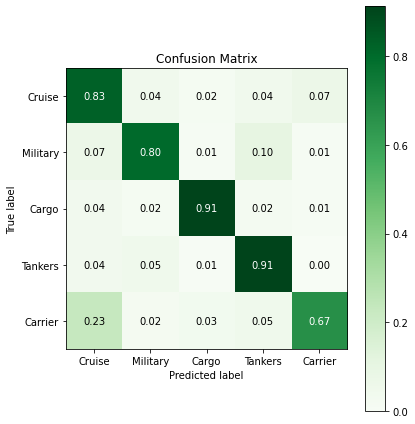

In [393]:
plot_confusion_matrix(true, valid_pred, normalize=True, 
                      classes=labels, title='Confusion Matrix')

In [59]:
#With Data augmentation
#CNN with sigmoid activation
model = Sequential()
model.add(Conv2D(128, 3, activation = 'sigmoid', padding = 'VALID', input_shape = (120,120,3)))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(64, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(32, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(32, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(16, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.4))
#model.add(Conv2D(8, 3, activation = 'sigmoid', padding = 'VALID', kernel_initializer = 'he_uniform'))



model.add(Flatten())
model.add(Dense(128, activation = 'sigmoid', kernel_initializer = 'he_uniform'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary())
model.save('model1.hdf5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 118, 118, 128)     3584      
_________________________________________________________________
batch_normalization_22 (Batc (None, 118, 118, 128)     512       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 59, 59, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 57, 57, 64)        73792     
_________________________________________________________________
batch_normalization_23 (Batc (None, 57, 57, 64)        256       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 26, 26, 32)       

In [60]:
#With Data augmentation
history = model.fit_generator(train_generator,
                              epochs = epochs,
                              validation_data = (X_test, y_test)
                              )

Epoch 1/15
51/51 [==============================] - 299s 6s/step - loss: 1.9302 - accuracy: 0.2284 - val_loss: 1.5866 - val_accuracy: 0.3389
Epoch 2/15
51/51 [==============================] - 364s 7s/step - loss: 1.8205 - accuracy: 0.2336 - val_loss: 1.5676 - val_accuracy: 0.3389
Epoch 3/15
51/51 [==============================] - 317s 6s/step - loss: 1.7431 - accuracy: 0.2555 - val_loss: 1.5551 - val_accuracy: 0.3389
Epoch 4/15
51/51 [==============================] - 332s 7s/step - loss: 1.7088 - accuracy: 0.2639 - val_loss: 1.5500 - val_accuracy: 0.3389
Epoch 5/15
51/51 [==============================] - 307s 6s/step - loss: 1.6724 - accuracy: 0.2725 - val_loss: 1.5463 - val_accuracy: 0.3389
Epoch 6/15
51/51 [==============================] - 317s 6s/step - loss: 1.6536 - accuracy: 0.2731 - val_loss: 1.5516 - val_accuracy: 0.3389
Epoch 7/15
51/51 [==============================] - 392s 8s/step - loss: 1.6338 - accuracy: 0.2777 - val_loss: 1.5482 - val_accuracy: 0.3389
Epoch 8/15
51

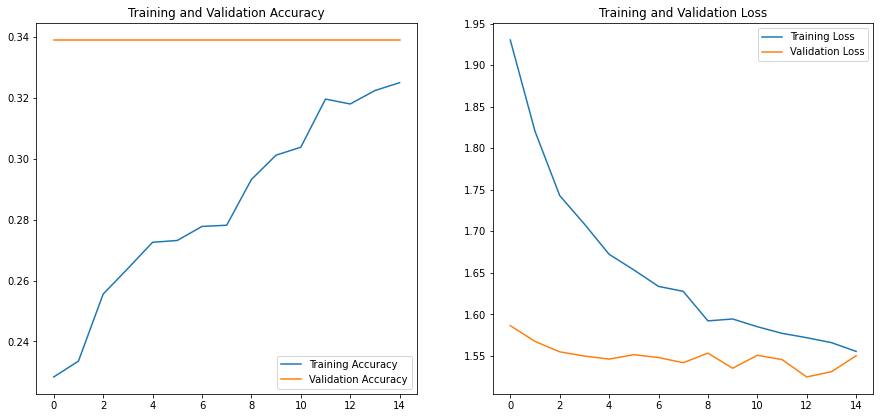

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [62]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 33.89%


In [63]:
from keras.models import load_model
f1 = printf1(X1_train, y1_train)
cp = ModelCheckpoint('best.hdf5', monitor='val_loss', save_best_only=True)


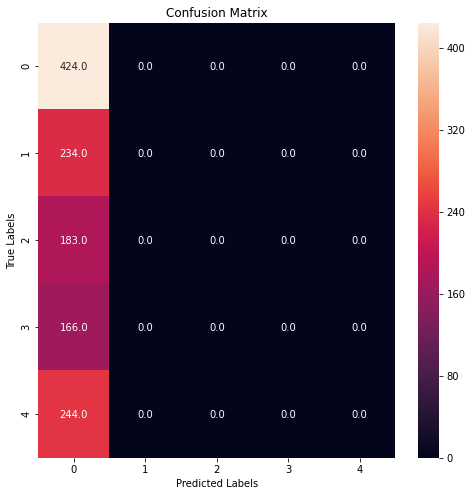

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicting labels from X_test data
y_pred = model.predict(X_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)

# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

In [67]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.34      1.00      0.51       424
           1       0.00      0.00      0.00       234
           2       0.00      0.00      0.00       183
           3       0.00      0.00      0.00       166
           4       0.00      0.00      0.00       244

    accuracy                           0.34      1251
   macro avg       0.07      0.20      0.10      1251
weighted avg       0.11      0.34      0.17      1251



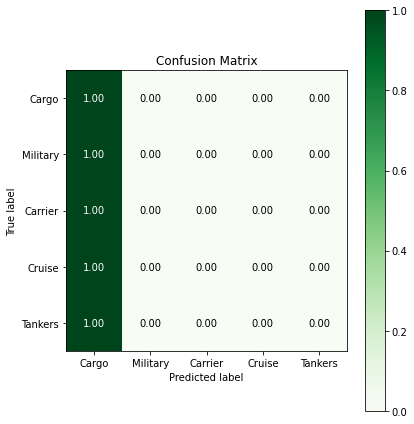

In [68]:
plot_confusion_matrix(true, valid_pred, normalize=True, 
                      classes=labels, title='Confusion Matrix')